In [1]:
import pandas as pd
import numpy as np
import random
import time
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import HDBSCAN
from ollama import chat
import numpy as np
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor, as_completed
from loader_clone import create_loaders

from representant_base import (
    Representant,
    DiversityStimulus,
    RepresentantGenerator,
    GenresDiversityHandler,
    PlotDiversityHandler,
)

In [2]:

import numpy as np
import pandas as pd

class EASE():
    """Implementation of EASE algorithm for EasyStudy using closed-form solution
    paper: https://arxiv.org/abs/1905.03375


    Internally, we assign binary ratings during training as that is the way it
    was done in the paper. As an alternative, we could predict the ratings, as
    is also mentioned in the paper.
    """

    def __init__(self, loader, positive_threshold, l2, **kwargs):
        self._ratings_df = None
        self._loader = loader
        self._all_items = None

        self._rating_matrix = None

        self._threshold = positive_threshold
        self._l2 = l2

        self._items_count = None

        self._weights = None

    # One-time fitting of the algorithm for a predefined number of iterations
    def fit(self, loader):
        print("FITTING EASE")

        self._loader = loader

        self._ratings_df = loader.ratings_df

        self._all_items = self._ratings_df.item.unique()

        self._rating_matrix = (
            self._loader.ratings_df.pivot(index="user", columns="item", values="rating")
            .fillna(0)
            .values
        )

        self._items_count =  np.shape(self._rating_matrix)[1]

        X = np.where(self._rating_matrix >= self._threshold, 1, 0).astype(np.float32)

        # Compute Gram matrix (G = X^T @ X)
        G = X.T @ X
        G += self._l2 * np.eye(self._items_count)  # Regularization

        # Compute the inverse of G
        P = np.linalg.inv(G)

        # Compute B matrix
        diag_P = np.diag(P)
        B = P / (-diag_P[:, None])  # Normalize rows by diagonal elements
        np.fill_diagonal(B, 0)  # Set diagonal to zero
        print("B matrix computed")
        self._weights = B

    # Predict for the user
    def predict(self, selected_items, filter_out_items, k, div_perception):
        rat = pd.DataFrame({"item": selected_items}).set_index("item", drop=False)
        # Appropriately filter out what was seen and what else should be filtered
        candidates = np.setdiff1d(self._all_items, rat.item.unique())
        candidates = np.setdiff1d(candidates, filter_out_items)
        if not selected_items:
            # Nothing was selected, since the new_user was unknown during training, Lenskit algorithm would simply recommended nothing
            # to avoid empty recommendation, we just sample random candidates
            return np.random.choice(candidates, size=k, replace=False).tolist()
        indices = list(selected_items)
        user_vector = np.zeros((self._items_count,), dtype=np.float32)
        for i in indices:
            user_vector[i] = 1.0

        preds = np.dot(user_vector, self._weights)

        relevance_scores = np.abs(preds)  

        return relevance_scores

In [3]:
_, loader = create_loaders()
print(loader.genres_embeddings.shape)

(1525, 384) (1525, 384)
(9456, 384) (9456, 384)
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456
(9456, 384)


In [4]:
# mapping for filtered dataset...
movie_ids = sorted(loader.ratings_df.movieId.unique())
id2idx = {mid: i for i, mid in enumerate(movie_ids)}
idx2id = {i: mid for mid, i in id2idx.items()}

# rename cols as in EasyStudy and map movieId to indices
ratings_mapped = (
    loader.ratings_df
    .rename(columns={"userId": "user",
                     "movieId": "item",
                     "rating": "rating"})
    .assign(item=lambda x: x["item"].map(id2idx))
    [["user", "item", "rating"]]
    .astype({"user": int, "item": int, "rating": float})
    .reset_index(drop=True)
)

loader.ratings_df = ratings_mapped

print(ratings_mapped.head())


   user  item  rating
0    16    74     1.0
1    16    86     1.5
2    16   213     1.0
3    16   313     2.0
4    16   347     1.0


In [5]:
# Split the dataset into train and validation set
train_df, val_df = train_test_split(
    ratings_mapped, test_size=0.2, stratify=ratings_mapped["user"], random_state=42 # stratify -> ensures that users are represented in both train and validation sets
)

# Ease works with collaborative data only
class MiniLoader:
    def __init__(self, ratings_df):
        self.ratings_df = ratings_df.copy()
        self.items_df = loader.movies_df.copy()
        self.genres_embeddings = loader.genres_embeddings.copy()
        self.plot_embeddings = loader.plot_embeddings.copy()

train_loader = MiniLoader(train_df)
val_loader   = MiniLoader(val_df)


In [6]:
def plot_filled_relevance_distributions_log_y(model, train_df, val_df, n_users=100, bins=100):
    users_all = val_df['user'].unique()
    users_sample = np.random.choice(users_all, size=min(n_users, len(users_all)), replace=False)

    plt.figure(figsize=(10, 6))
    y_floor = 1e-1  # min value for log-scale

    for user_id in users_sample:
        seen_items = train_df[train_df.user == user_id]["item"].tolist()
        filter_out_items = seen_items

        relevance_scores = model.predict(
            selected_items=seen_items,
            filter_out_items=filter_out_items,
            k=1000,
            div_perception=None
        )

        rel_scores = np.array(relevance_scores)

        # Avoid influence of extreme outliers
        max_val = np.percentile(rel_scores, 99)
        counts, bin_edges = np.histogram(rel_scores, bins=bins, range=(0, max_val), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Clip small values for log scale
        counts = np.clip(counts, y_floor, None)

        plt.fill_between(bin_centers, counts, alpha=0.07, color="steelblue")

    plt.yscale("log")
    plt.ylim(bottom=y_floor)  # Ensures visible min on log scale
    plt.title("Overlay of Filled Relevance Score Distributions (100 Users, Log Y)", fontsize=13)
    plt.xlabel("Relevance Score")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


In [7]:
algo = EASE(loader=train_loader, positive_threshold=2.5, l2=500)
algo.fit(train_loader)



FITTING EASE
B matrix computed


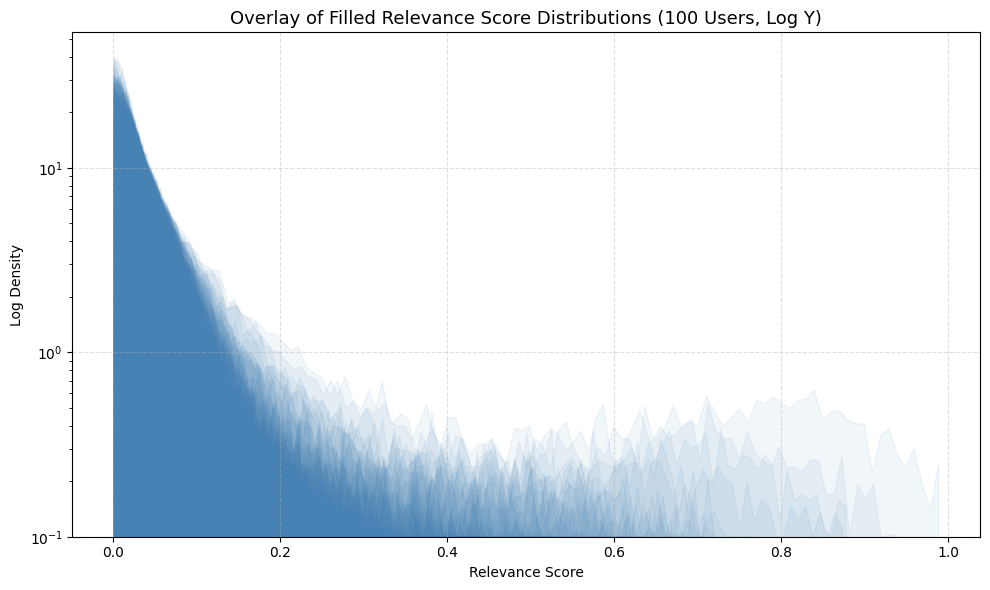

In [8]:
plot_filled_relevance_distributions_log_y(model=algo, train_df=train_df, val_df=val_df)


In [9]:
def get_random_user(val_df):
    # Randomly pick one user from the validation dataframe
    return np.random.choice(val_df['user'].unique())

def get_relevance_scores(model, train_df, user_id, k=1000):
    # Get items the user has already seen to filter them out during prediction
    seen_items = train_df[train_df.user == user_id]["item"].tolist()
    relevance_scores = model.predict(
        selected_items=seen_items,
        filter_out_items=seen_items,
        k=k,
        div_perception=None
    )
    # Reshape to column vector for consistency
    return np.array(relevance_scores).reshape(-1, 1)

def apply_quantile_transform(scores, output_distribution="normal"):
    # Map scores to a specified distribution using quantile transformation
    qt = QuantileTransformer(output_distribution=output_distribution, random_state=42)
    scores_q = qt.fit_transform(scores)
    # Return both transformed scores and the transformer object
    return scores_q, qt

def plot_distributions(original_scores, transformed_scores, bins=50):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    def plot_bar(ax, scores, title, color, log_y=False):
        counts, bin_edges = np.histogram(scores, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), color=color, alpha=0.7, edgecolor='k')
        if log_y:
            ax.set_yscale("log")
        ax.set_xlabel("Score")
        ax.set_ylabel("Count" + (" (log scale)" if log_y else ""))
        ax.grid(True, linestyle="--", alpha=0.4)

    # Plot original scores with log scale to handle skewness
    plot_bar(axs[0], original_scores.flatten(), "Original relevance counts", "steelblue", log_y=True)
    # Plot transformed scores with linear scale for easier interpretation
    plot_bar(axs[1], transformed_scores.flatten(), "Quantile transformed normal", "coral", log_y=False)

    plt.tight_layout()
    plt.show()

def compare_scores_by_value_bins(original_scores, transformed_scores, num_bins=10):
    scores_flat = original_scores.flatten()
    transformed_flat = transformed_scores.flatten()

    # Create linearly spaced bin edges between min and max original scores
    min_val, max_val = scores_flat.min(), scores_flat.max()
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    selected_orig = []
    selected_trans = []

    # Iterate over bins, selecting a representative score from each bin
    for b_start, b_end in zip(bin_edges[:-1], bin_edges[1:]):
        # Mask to select scores falling within current bin interval
        mask = (scores_flat >= b_start) & (scores_flat < b_end)
        bin_scores = scores_flat[mask]
        if len(bin_scores) > 0:
            # Choose score closest to the bin center as representative
            center_val = b_start + (b_end - b_start) / 2
            closest_idx = np.argmin(np.abs(bin_scores - center_val))
            orig_val = bin_scores[closest_idx]
            # Find the index of this representative score in the flattened array
            orig_idx = np.where(scores_flat == orig_val)[0][0]
            selected_orig.append(orig_val)
            selected_trans.append(transformed_flat[orig_idx])

    print("\nValue-Binned Score Comparison (Original -> Quantile Normalized):\n")
    print(f"{'Original':>10}    {'Transformed (Normal)':>25}")
    print("-" * 40)
    for o, t in zip(selected_orig, selected_trans):
        print(f"{o:10.4f}    {t:25.4f}")

def analyze_random_user_relevance(model, train_df, val_df):
    user_id = get_random_user(val_df)
    print(f"\nRandomly selected user: {user_id}")

    scores = get_relevance_scores(model, train_df, user_id)
    scores_q, _ = apply_quantile_transform(scores, output_distribution='normal')

    plot_distributions(scores, scores_q)
    compare_scores_by_value_bins(scores, scores_q)

    return user_id, scores.flatten(), scores_q.flatten()



Randomly selected user: 102545


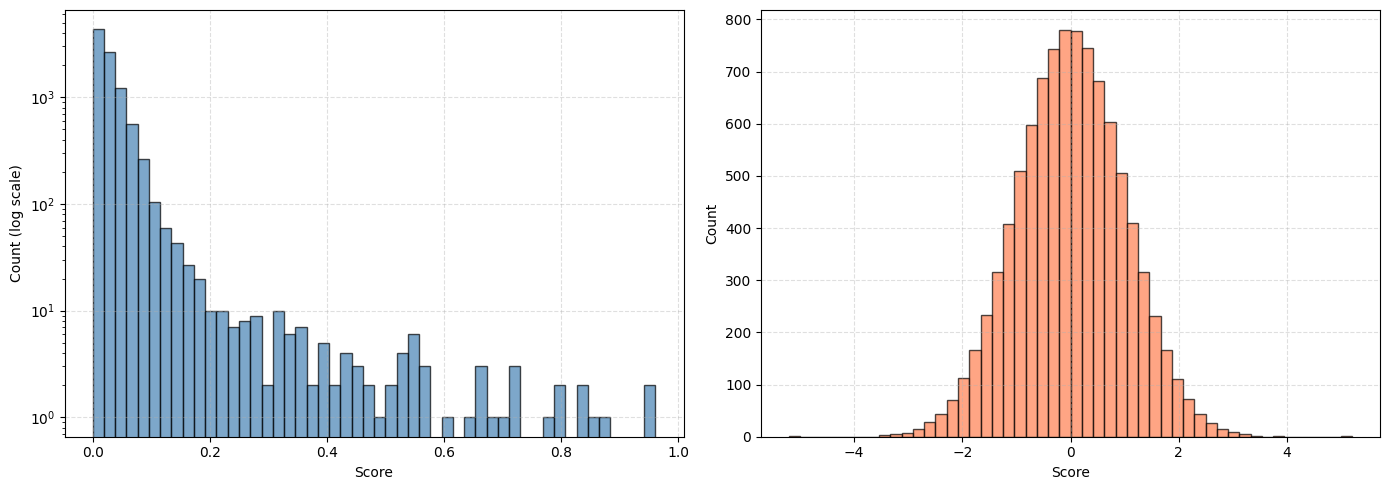


Value-Binned Score Comparison (Original -> Quantile Normalized):

  Original         Transformed (Normal)
----------------------------------------
    0.0480                       0.9198
    0.1438                       2.0594
    0.2397                       2.3094
    0.3336                       2.4742
    0.4274                       2.6102
    0.5265                       2.7368
    0.6093                       2.9235
    0.7155                       3.0903
    0.8036                       3.2201
    0.8795                       3.4047


In [10]:
user_id, original, quantile = analyze_random_user_relevance(model=algo, train_df=train_df, val_df=val_df)


In [ ]:
class LLMProfiling():

    def __init__(self, loader, positive_threshold, l2, **kwargs):
        self._ratings_df = None
        self._loader = None
        self._all_items = None

        self._model = None

        self._hdbscan_clusterer = None

        self.stimulus_handlers: dict[DiversityStimulus, type[RepresentantGenerator]] = {
            DiversityStimulus.GENRES: GenresDiversityHandler,
            DiversityStimulus.PLOT: PlotDiversityHandler,
        }

        self.diversity_stimulus = None

        self._rating_matrix = None

        self._threshold = positive_threshold
        self._l2 = l2

        self._items_count = None

        self._weights = None

    def fit(self, loader):

        self._ratings_df = loader.ratings_df
        self._loader = loader
        self._all_items = self._ratings_df.item.unique()

        self._model = SentenceTransformer('all-MiniLM-L6-v2')

        self._hdbscan_clusterer = HDBSCAN(
            min_cluster_size=2,
            min_samples=None,
            metric='cosine',
        )

        self._rating_matrix = (
            self._loader.ratings_df.pivot(index="user", columns="item", values="rating")
            .fillna(0)
            .values
        )

        self._items_count =  np.shape(self._rating_matrix)[1]

        X = np.where(self._rating_matrix >= self._threshold, 1, 0).astype(np.float32)

        # Compute Gram matrix (G = X^T @ X)
        G = X.T @ X
        G += self._l2 * np.eye(self._items_count)  # Regularization

        # Compute the inverse of G
        P = np.linalg.inv(G)

        # Compute B matrix
        diag_P = np.diag(P)
        B = P / (-diag_P[:, None])  # Normalize rows by diagonal elements
        np.fill_diagonal(B, 0)  # Set diagonal to zero
        print("B matrix computed")
        self._weights = B

    # Predict for the user
    def predict(self, selected_items, filter_out_items, k, dominant_stimulus_weight, dominant_stimulus):
        #print("Selected", selected_items)
        #print("Filter out", filter_out_items)

        indices = list(selected_items)
        user_vector = np.zeros((self._items_count,), dtype=np.float32)
        for i in indices:
            user_vector[i] = 1.0

        relevance_scores = np.dot(user_vector, self._weights)
        relevance_scores = apply_quantile_transform(relevance_scores.reshape(-1, 1), output_distribution='normal')[0].flatten()

        MAX_CLUSTERS = 3
        
        self.diversity_stimulus = dominant_stimulus
        if self.diversity_stimulus == DiversityStimulus.GENRES:
            genre_weight = dominant_stimulus_weight
            plot_weight = 1 - dominant_stimulus_weight
        else:
            plot_weight = dominant_stimulus_weight
            genre_weight = 1 - dominant_stimulus_weight

        # Prepare user-preferred movies based on selected items
        user_preferred_movies = []
        for item in selected_items:
            user_preferred_movies.append(self._loader.items_df.iloc[item])

        # #print("PREF MOVIES:", user_preferred_movies)

        # Update the final embedding calculation with the genre and plot weights
        final_embedding = genre_weight * self._loader.genres_embeddings + plot_weight * self._loader.plot_embeddings
        #print("final embed shape", final_embedding.shape)
        
        mask = np.ones(final_embedding.shape[0], dtype=bool)
        mask[filter_out_items] = 0
        relevance_scores[filter_out_items] = 0
        original_indices = np.where(mask)[0]
        emb_matrix = final_embedding[mask]
        
        user_genre_embeddings = self._model.encode([movie['genres'] for movie in user_preferred_movies])
        user_plot_embeddings = self._model.encode([movie['plot'] for movie in user_preferred_movies])
        user_embeddings = genre_weight * user_genre_embeddings + plot_weight * user_plot_embeddings
        #print(user_embeddings.shape)

        #print("clustering")
        
        cluster_labels = self._hdbscan_clusterer.fit_predict(user_embeddings)
        #print("clustering DONE")
        #print(cluster_labels)
        clusters = {}

        # Check if clusters have been found
        if len(np.unique(cluster_labels)) == 1:
            random_indices = np.random.choice(len(user_preferred_movies), size=min(len(user_preferred_movies),MAX_CLUSTERS), replace=False)
            for i in random_indices:
                label = "random_" + str(i)
                clusters[label] = user_preferred_movies[i]

        else:
            # Get at most 3 largest clusters, igrnoring noise
            labels, counts = np.unique(cluster_labels[cluster_labels != -1], return_counts=True)
            top_clusters = labels[np.argsort(-counts)[:MAX_CLUSTERS]]
            #print("Top clusters:", top_clusters)

            cluster_mask = ~np.isin(cluster_labels, top_clusters)
            #print(cluster_labels)
            cluster_labels[cluster_mask] = -1
            #print(cluster_labels)

            for i in range(len(user_preferred_movies)):
                label = cluster_labels[i]
                movie_info = user_preferred_movies[i]
                if label == -1:
                    continue # Skip noise movies
                if label not in clusters:
                    clusters[str(label)] = []
                #print(f"Adding movie {movie_info['title']} to cluster {label}")
                clusters[str(label)].append(movie_info)

        tasks = list(clusters.items())

        def _produce(label, data):
            """Runs *inside* a worker thread — keep heavy code here."""
            if label.startswith("random_"):
                rep = Representant(genres=data["genres"], plot=data["plot"])
            else:
                # potentially slow call
                rep = self._generate_representant(list(data)[:5], self.diversity_stimulus)

            if not rep:                         # return sentinel on failure
                return label, None, None

            rep_genre_embeddings = self._model.encode([rep.genres])
            rep_plot_embeddings = self._model.encode([rep.plot])
            rep_embeddings = genre_weight * rep_genre_embeddings + plot_weight * rep_plot_embeddings

            return label, rep, rep_embeddings

        representants                 = []
        representant_embeddings_dict  = {}

        with ThreadPoolExecutor(max_workers=len(tasks)) as pool:
            futures = [pool.submit(_produce, lbl, data) for lbl, data in tasks]

            for fut in as_completed(futures):
                label, rep, emb = fut.result()
                if rep is not None:
                    representants.append(rep)
                    representant_embeddings_dict[label] = emb
        
        #print("\n--- Generating Diversity Representant ---")
        div_representant = self._generate_diversity_representant(representants, self.diversity_stimulus)
        if div_representant:
            #print(f"Generated diversity representant:", div_representant)
            rep_genre_embeddings = self._model.encode([div_representant.genres])
            rep_plot_embeddings = self._model.encode([div_representant.plot])
            rep_embeddings = genre_weight * rep_genre_embeddings + plot_weight * rep_plot_embeddings
            representant_embeddings_dict["diversity"] = rep_embeddings
        else:
            #print("Could not generate diversity representant.")
            pass

        # Find similar embeddings, movies
        used_items = set()
        cluster_candidates = {}
        for cluster_id, rep_emb in representant_embeddings_dict.items():
            similarities = cosine_similarity(rep_emb.reshape(1, -1), emb_matrix)[0]
            # multiply similarities by preds item wise
            similarities = apply_quantile_transform(similarities.reshape(-1, 1), output_distribution='normal')[0].flatten()
            similarities = similarities * relevance_scores[mask]
            closest_indices = np.argsort(-similarities)[:k]
            top_k_original_indices = original_indices[closest_indices]
            cluster_candidates[cluster_id] = [int(i) for i in top_k_original_indices if int(i) not in used_items]

        # Create result in round-robin way
        # TODO: Use LLM to re-rank the items ? or half of them ?
        cluster_ids = list(cluster_candidates.keys())
        result = []
        i = 0
        while len(result) < k and any(cluster_candidates.values()):
            cluster_id = cluster_ids[i % len(cluster_ids)]
            candidates = cluster_candidates[cluster_id]

            if candidates:
                candidate = candidates.pop(0)
                if candidate not in used_items:
                    result.append(candidate)
                    used_items.add(candidate)
            i += 1

        #print("LLMprofiling done")

        return result[:k]

    def _generate_representant(self, movies_cluster, stimulus: DiversityStimulus):
            
        handler = self.stimulus_handlers[stimulus]()

        return handler.generate_cluster_representant(movies_cluster)
    
    def _generate_diversity_representant(self, representants, stimulus: DiversityStimulus):

        handler = self.stimulus_handlers[stimulus]()

        return handler.generate_diversity_representant(representants)
    

In [ ]:
def explore_weights_ranked(model, train_df, val_df, k, n_users):
    min_weight = 0.2
    max_weight = 0.8
    rank_points = [3, 2, 1]  # Points for top 3 F1 scores
    output_csv_path = "weight_scores_300.csv"

    weights = [round(w, 1) for w in np.arange(min_weight, max_weight + 0.01, 0.1)]

    users_all = val_df.user.unique()
    users_sample = np.random.choice(users_all, size=min(n_users, len(users_all)), replace=False)

    results = []
    no_connection = False

    print(f"Running exploration on {len(users_sample)} users.\n")

    for i, user_id in enumerate(users_sample, 1):
        print(f"Processing user {i}/{len(users_sample)}: {user_id}")

        true_items = val_df[val_df.user == user_id]["item"].tolist()
        seen_items = train_df[train_df.user == user_id]["item"].tolist()

        user_results = []

        for weight in weights:
            recs = None
            for attempt in range(3):
                try:
                    recs = model.predict(
                        selected_items=seen_items,
                        filter_out_items=seen_items,
                        k=k,
                        dominant_stimulus=DiversityStimulus.GENRES,
                        dominant_stimulus_weight=weight
                    )
                    break
                except Exception as e:
                    print(f"Prediction failed for user {user_id}, weight {weight}, attempt {attempt+1}/3: {e}")
                    if attempt < 2:
                        time.sleep(10)
                    else:
                        print("Maximum retries reached. Ending early.")
                        no_connection = True
                        break

            if no_connection:
                break

            hits = len(set(recs) & set(true_items)) if recs else 0
            precision = hits / k if k else 0.0
            recall = hits / len(true_items) if true_items else 0.0
            f1 = 0.0 if precision + recall == 0 else (2 * precision * recall) / (precision + recall)

            user_results.append({
                "user": user_id,
                "weight_genres": weight,
                "weight_plot": 1 - weight,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })

        if no_connection:
            break

        # Rank top 3 by F1
        ranked = sorted(user_results, key=lambda x: x["f1"], reverse=True)
        for rank, points in enumerate(rank_points):
            if rank < len(ranked):
                ranked[rank]["points"] = points
        for entry in ranked[len(rank_points):]:
            entry["points"] = 0

        results.extend(ranked)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)

    summary = (
        results_df
        .groupby(["weight_genres", "weight_plot"])["points"]
        .sum()
        .reset_index()
        .sort_values("points", ascending=False)
    )

    print("\nTotal points by weight combination")
    print(summary)

    return results_df, summary


In [15]:
algo = LLMProfiling(loader=train_loader, positive_threshold=2.5, l2=500)
algo.fit(train_loader)

B matrix computed


In [21]:
results_df, summary_df = explore_weights_ranked(
    model=algo,
    train_df=train_loader.ratings_df,
    val_df=val_loader.ratings_df,
    k=6,
    n_users=300
)


Running exploration on 300 users.

Processing user 1/300: 4334
Processing user 2/300: 200211
Processing user 3/300: 15939
Processing user 4/300: 152325
Processing user 5/300: 179863
Processing user 6/300: 101955
Processing user 7/300: 116919
Processing user 8/300: 175111
Processing user 9/300: 175893
Processing user 10/300: 196128
Processing user 11/300: 137080
Processing user 12/300: 116763
Processing user 13/300: 31671
Processing user 14/300: 115208
Processing user 15/300: 37388
Processing user 16/300: 54023
Processing user 17/300: 110141
Processing user 18/300: 127637
Processing user 19/300: 100079
Processing user 20/300: 18140
Processing user 21/300: 110280
Processing user 22/300: 119490
Processing user 23/300: 2260
Processing user 24/300: 93624
Processing user 25/300: 41433
Processing user 26/300: 136480
Processing user 27/300: 199215
Processing user 28/300: 181652
Processing user 29/300: 1804
Processing user 30/300: 19984
Processing user 31/300: 164120
Processing user 32/300: 140

In [3]:
input_csv_path = "weight_scores_300.csv"

results_df = pd.read_csv(input_csv_path)

summary = (
    results_df
    .groupby(["weight_genres", "weight_plot"])["points"]
    .sum()
    .reset_index()
    .sort_values("points", ascending=False)
)

print(summary)

   weight_genres  weight_plot  points
0            0.2          0.8     453
1            0.3          0.7     340
2            0.4          0.6     274
3            0.5          0.5     239
5            0.7          0.3     173
6            0.8          0.2     161
4            0.6          0.4     160
